In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import tensorflow as tf
import cv2
import glob
from PIL import Image
from matplotlib.widgets import Button
from pose_parameter import PoseParameter
import sys
from scipy import signal
import cmapy
import gc
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.draw import disk


2023-07-03 07:48:28.093255: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 07:48:28.095105: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 07:48:28.130689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 07:48:28.131497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 07:48:28.766391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
class PoseDraw():
    def __init__(self):
        poseParamObj    = PoseParameter()
        self.limbs      = poseParamObj.getLimbs()
        self.limb_color = poseParamObj.getLimbColor()
        self.part_color = poseParamObj.getPartColor()
        self.parts = poseParamObj.getBodyParts()

    def drawPose(self, inputImg, data):
        data_int = np.int32(data[...,::-1])

        # Draw limbs
        for data_pers in data_int:
            for i, pair in enumerate(self.limbs):
                if np.all(data_pers[pair]):
                    inputImg = cv2.line(inputImg, tuple(data_pers[pair[0]]),
                                        tuple(data_pers[pair[1]]),
                                        self.limb_color[i], 2)

        # Draw body parts
        non_zero_data = data_int[np.all(data_int, axis=-1)]
        idx = np.tile(np.arange(data_int.shape[1])[np.newaxis], (data_int.shape[0],1))[np.all(data_int, axis=-1)]
        for i, data_kp in zip(idx, non_zero_data):
            inputImg = cv2.circle(inputImg, tuple(data_kp),3, self.part_color[i],
                                thickness=-1)

        return inputImg
    
def preprocess_img(img, target_size):
    diff = np.max(img.shape[:-1]) - np.min(img.shape[:-1])
    border_1 = (diff + 1) // 2
    border_2 = diff // 2

    # Crop
    if np.argmax(img.shape[:-1]) == 0:
        img = img[border_1:img.shape[0]-border_2]
    elif np.argmax(img.shape[:-1]) == 1:
        img = img[:,border_1:img.shape[1]-border_2]
    else:
        raise Exception('img has invalid shape!')

    # Scaling
    img = resize(img, (target_size,target_size), anti_aliasing=True)

    # Correct dtype and shape
    if np.max(img) <= 1.0:
        img = np.float32(img * 255.0)[np.newaxis]
    else:
        img = np.float32(img)[np.newaxis]

    return img



In [5]:
def DL(img):
    img_size = 256
   
    # Load model
    model = tf.keras.models.load_model('trained_model/ICAIPose/models/ICAIPose_best.h5')
    tf.keras.utils.plot_model(model, show_shapes=True)
    # Load validation image
    # img = imread('out.jpg')
    img_pp = preprocess_img(img, img_size)

    # Run ICAIPose
    offset = np.array([103.939, 116.779, 123.68], dtype='float32')[None,None,None,:]
    out = model(img_pp[...,::-1]-offset)
    return out

def post_old(conf, img):
    
    drawObj = PoseDraw()
    parts = drawObj.parts
    org_size = np.shape(img)[0]
    conf_thresh = 0.2
    conf_map = np.moveaxis(conf[-1][0,:,:,:-1], [0,1,2], [1,2,0])
    kp_location = np.array([np.unravel_index(np.argmax(cm), cm.shape) for cm in conf_map])
    kp_confidence = np.array([np.max(cm) for cm in conf_map])
    kp_location[kp_confidence < conf_thresh] = 0

    # Draw result
    img_draw = drawObj.drawPose(img, org_size/256*kp_location[None])
    return img_draw

In [62]:
def post_new(conf, img):

    # conf_in = np.copy(conf)

    conf_map = np.moveaxis(conf[-1][0,:,:,:-1], [0,1,2], [1,2,0])
    org_size = np.shape(img)[0]
    conf_map_local = np.copy(conf_map)

    color_part = [(153,0,51),  # Nose
                (153,0,0),   # Neck
                (153,51,0),  # RShoulder
                (153,102,0), # RElbow
                (153,153,0), # RWrist
                (102,153,0), # LShoulder
                (51,153,0),  # LElbow
                (0,153,0),   # LWrist
                (153,0,0),   # MidHip
                (0,153,51),  # RHip
                (0,153,102), # RKnee
                (0,153,153), # RAnkle
                (0,102,153), # LHip
                (0,51,153),  # LKnee
                (0,0,153)]   # LAnkle

    limbs   = np.array([[0,1],
                        [1,2],
                        [2,3],
                        [3,4],
                        [1,5],
                        [5,6],
                        [6,7],
                        [1,8],
                        [8,9],
                        [9,10],
                        [10,11],
                        [8,12],
                        [12,13],
                        [13,14]], dtype='uint16')

    color_limb =        [(153,0,51),  # Neck
                        (153,51,0),  # RShoulder
                        (153,102,0), # RUpperArm
                        (153,153,0), # RForearm
                        (102,153,0), # LShoulder
                        (51,153,0),  # LUpperArm
                        (0,153,0),   # LForearm
                        (153,0,0),   # Back
                        (0,153,51),  # RHiplimbs
                        (0,153,102), # RTight
                        (0,153,153), # RLowerLeg
                        (0,102,153), # LHip
                        (0,51,153),  # LTight
                        (0,0,153)]   # LLowerLeg

    keypoints = []
    # for cm in conf_map_local:
    #     cm[cm<0.2] = 0
    #     coordinates = peak_local_max(cm, min_distance=20, exclude_border=0)
    #     keypoints.append((org_size/256*coordinates).astype(np.int32)[...,::-1])

    for cm in conf_map_local:
        kp = []
        cm[cm<0.2] = 0
        while True:
            if np.argmax(cm) == 0:
                break
            max = np.unravel_index(np.argmax(cm), cm.shape)
            rr, cc = disk(max, 25, shape=(256,256))
            cm[rr, cc] = 0
            kp.append(max)
        keypoints.append((org_size/256*np.array(kp)).astype(np.int32)[...,::-1])


    # keypoints = np.int32(org_size/256*np.array(keypoints))[...,::-1]
    cnt = 0
    for kps in keypoints:
        for kp in kps:
            img = cv2.circle(img, tuple(kp), 3, color_part[cnt], thickness=-1)
        cnt += 1


    for k, (a,b) in enumerate(limbs):
        pts = []
        flag = False
        dist_out = []
        for kp in keypoints[a]:
            if len(keypoints[a]) > len(keypoints[b]):
                dist = []
                flag = True
                for j in range(len(keypoints[b])):
                    dist.append(np.linalg.norm(kp-keypoints[b][j]))
                    pts.append([kp, keypoints[b][j]])
                dist_out.append(dist)
            else:
                dist = []
                for j in range(len(keypoints[b])):
                    dist.append(np.linalg.norm(kp-keypoints[b][j]))
                pts.append([kp, keypoints[b][np.argmin(dist)]])
        if flag:
            pts = np.array(pts)
            pts = pts[np.argsort(np.array(dist_out).flatten())[:min(len(keypoints[a]), len(keypoints[b]))]]
            flag = False
        for p1, p2 in pts:
            img = cv2.line(img, p1, p2, color_limb[k], 2)
    return img

def post_conf(conf):
    
    conf = np.moveaxis(conf[-1][0,:,:,:-1], [0,1,2], [1,2,0])

    conf_map = np.copy(conf)

    # conf_map[conf_map<20] = 0

    conf_map = np.sum(conf_map, axis=0)
    # conf_map = (conf_map-np.min(conf_map))/(np.max(conf_map)-np.min(conf_map))
    return conf_map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


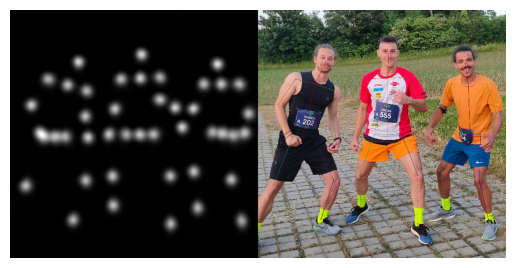

In [67]:
# imgs = np.load('validation_data/imgs.npy')
imgs = [imread('data/multi.jpg')]
import time

for i in range(1): 
    conf = DL(imgs[i])
    # np.save('conf.npy',conf[-1])

    # t = time.time()
    new = post_new(conf, imgs[i])
    new2 = post_conf(conf)
    new2 = cv2.cvtColor(new2,cv2.COLOR_GRAY2RGB)
    new = cv2.resize(new, (512, 512))
    new2 = cv2.resize(new2, (512, 512))

    img_draw = np.hstack((new2, new/255 ))

    # print(time.time()-t)
    # # t = time.time()
    # # old = post_old(conf, imgs[i])
    # # print(time.time()-t)
    # # print()

    _, axis = plt.subplots(1,1)
    axis.imshow(img_draw)
    axis.axis("off")


(-0.5, 255.5, 255.5, -0.5)

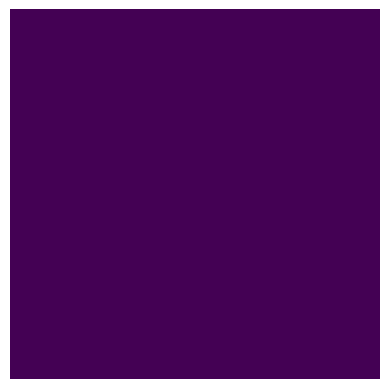

In [10]:
from skimage.draw import disk

conf_map = np.moveaxis(conf[-1][0,:,:,:-1], [0,1,2], [1,2,0])

from skimage.morphology import reconstruction

conf_map = conf_map[0] > 0.2
kp = []

for i in range(3):
    max = np.unravel_index(np.argmax(conf_map), conf_map.shape)
    rr, cc = disk(max, 20)
    kp.append(max)
    conf_map[rr, cc] = 0

# res = ndimage.binary_dilation(res)

cnt = 0
for kps in keypoints:
    for kp in kps:
        img = cv2.circle(img, tuple(kp), 20, color_part[cnt], thickness=-1)
    cnt += 1

_, axis = plt.subplots(1,1)
axis.imshow(conf_map)
axis.axis("off")